In [1]:
import os
import mne
import random
import re
import shutil

import numpy as np
import pandas as pd
import scikitplot as skplt
import scipy.io as io
import tensorflow as tf


from pywt import wavedec
from sklearn.model_selection import train_test_split
from tensorflow import keras
from typing import List

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
filename = "resources/dane_eeg.zip"
extract_dir = "resources/dane_eeg"
seizure_occ_file = "resources/dane_eeg/czasy_napadow.m"
healthy_dir = "resources/dane_eeg/zdrowi"
unhealthy_dir = "resources/dane_eeg/chorzy"
img_dir = "resources/dane_eeg/images/"

# shutil.unpack_archive(filename, extract_dir)

In [3]:
def get_mat_files(base_path): 
    mat_files_list = []
    filenames = {}

    for file in os.listdir(base_path):
        if file.endswith(".mat"):
            mat_files_list.append(base_path + "/" + file)
            
    for filename in mat_files_list:        
        filenames[filename.split('/')[-1].split('_')[0]] = filename
        
    return mat_files_list, filenames


healthy_paths, healthy_patients_dict = get_mat_files(healthy_dir)
unhealthy_paths, unhealthy_patients_dict = get_mat_files(unhealthy_dir)

In [4]:
def get_all_seizure_occurrences(file_path):
    all_occurrences = {}
    with open (file_path , 'r') as file:
        for line in file :
            line_number = int(re.search(r'{([0-9]+)}', line).group(1))
            occ_list = list(map(int, re.search(r'\[(.+?)]', line).group(1).split()))
            all_occurrences[line_number] = occ_list
    return all_occurrences


seizure_occurrences = get_all_seizure_occurrences(seizure_occ_file)

In [5]:
class Seizure:
    def __init__ (self, id, filename, samples, seizure_occurrences=None, frequency=100, channels=16) -> None :
        super (). __init__ ()
        self.id = id
        self.filename = filename
        self.samples = samples
        self.seizure_occurrences = seizure_occurrences
        self.frequency = frequency
        self.channels = channels

In [6]:
def healthy_patients(healthy_people_dict):
    healthy_patients = []
    for id, path in healthy_people_dict.items():
        samples = io.loadmat(path)['x']
        filename = os.path.basename(path)
        healthy_patients.append(Seizure(id, filename, samples))
 
    return healthy_patients

def unhealthy_patients(unhealthy_people_dict, seizure_occurrences):
    unhealthy_patients = []
    for id, path in unhealthy_people_dict.items():
        seizure_occ = seizure_occurrences[int(id)]
        samples = io.loadmat(path)['x']
        filename = os.path.basename(path)
        unhealthy_patients.append(Seizure(id, filename, samples, seizure_occurrences=seizure_occ))
 
    return unhealthy_patients

In [7]:
healthy_list: List[Seizure] = healthy_patients(healthy_patients_dict)
unhealthy_list: List[Seizure] = unhealthy_patients(unhealthy_patients_dict, seizure_occurrences)

In [8]:
# def saveToPng(figure, filename, img_dir, seizure_time):
#     base_filename = os.path.splitext(filename)[0]
#     dir_name = img_dir + base_filename
#     if not os.path.exists(dir_name):
#         os. makedirs(dir_name)
#     figure.savefig(dir_name + '/' + base_filename + str(seizure_time) + '.png')


# def plot_all_attacks(unhealthy_people, save_to_png=False, img_dir=""):
#  # colored blocks for visualization of attack
#     def create_annotations(occurrences):
#         events = [x for x in occurrences ]
#         return mne.Annotations(onset=events, duration=2, description=['seizure ' + str(x) for x in occurrences])

#     def visualize(filename, samples, seizure_time, all_events, save_to_png):
#         ch_names = list(map(str,range(1,17))) 
#         info = mne.create_info(ch_names=ch_names, sfreq =100)
#         raw = mne.io.RawArray(np.transpose(samples), info)
#         raw.set_annotations(all_events)

#         figure = raw.plot(n_channels=16, scalings='auto', title=filename + 'Time_of_seizure: ' + str(seizure_time), block=False, start=max(0, seizure_time - 5), duration=10)
 
#         if save_to_png:
#             saveToPng(figure, filename, img_dir, seizure_time)

#     for person in unhealthy_people:
#         all_events = create_annotations(person.seizure_occurrences)
#         for seizure_time in person.seizure_occurences:
#             visualize(person.filename, person.samples, seizure_time, all_events, save_to_png)
            
# def plot_healthy(healthy_people, save_to_png=False, img_dir=""):
#  # colored blocks for visualization of attack
#     def visualize(filename, samples, seizure_time, all_events, save_to_png):
#         ch_names = list(map(str,range(1,17))) 
#         info = mne.create_info(ch_names=ch_names, sfreq =100)
#         raw = mne.io.RawArray(np.transpose(samples), info)
#         raw.set_annotations(all_events)

#         figure = raw.plot(n_channels=16, scalings='auto', title=filename + 'Time_of_seizure: ' + str(seizure_time), block=False, start=max(0, seizure_time - 5), duration=10)
 
#         if save_to_png:
#             saveToPng(figure, filename, img_dir, seizure_time)

#     for person in unhealthy_people:
#         all_events = create_annotations(person.seizure_occurrences)
#         for seizure_time in person.seizure_occurences:
#             visualize(person.filename, person.samples, seizure_time, all_events, save_to_png)

In [9]:
# plot_all_attacks(unhealthy_list, save_to_png = True, img_dir=img_dir)
# list(map(str,range(1,17))) 

In [10]:
# def plot_seizures_of_patient(unhealthy_people, patient_nr, channels_no =1):
#     patient = next((x for x in unhealthy_people if x.id == str(patient_nr)), 0)
#     info = mne.create_info(ch_names = list(map(str,range(1,17))), sfreq = 100, ch_types ='eeg')
#     raw = mne.io.RawArray(np.transpose(patient.samples), info)
#     annot = mne.Annotations(onset = patient.seizure_matches, duration = 2, description = patient.seizure_matches) 
#     raw.set_annotations(annot)
#     plot_kwargs = {
#         'scalings': dict(eeg=30),
#         'highpass': 1,
#         'lowpass': 40,
#         'n_channels': channels_no,
#         'duration': 10,
#     }

#     for seizure in patient.seizure_occurences:
#         raw.plot(**plot_kwargs, start = seizure - 2)

In [11]:
for patient in healthy_list:
    patient.samples = np.delete(patient.samples, -1, axis =1)

In [12]:
healthy_epochs = []
for patient in healthy_list:
  samples = patient.samples
  for i in range(0, samples.shape[0] - 100, 200):
    chunk = samples[i:i + 200]
    healthy_epochs.append(('healthy', chunk))


unhealthy_epochs = []
for patient in unhealthy_list:
    samples = patient.samples
    for seizure_time in patient.seizure_occurrences:
        seizure_start = seizure_time * 100
        chunk = samples[seizure_time:seizure_time + 200]
        unhealthy_epochs.append(('unhealthy', chunk))


chunks_healthy_from_sick = []
for patient in unhealthy_list:
    samples = patient.samples
    occurrences = patient.seizure_occurrences
    indexes = [i * 100 for i in occurrences]

    # divide by seizure matches
    chunks = np.split(samples, indexes)
    chunks_healthy = [chunks[0][: -400]]

     # remove 4 seconds of potential seizure from each chunk
    for element in chunks [1:]:
        chunks_healthy.append(element[400:])

     # split each chunk for healthy waves
        for e in chunks_healthy:
            for i in range(0, e.shape [0] - 100, 200):
                chunk = e[i:i + 200]
                chunks_healthy_from_sick.append(('healthy', chunk))

In [90]:
true_healthy = random.sample(healthy_epochs, 5000)
# len(healthy_epochs)
all_epochs = true_healthy + unhealthy_epochs
len(all_epochs)

5588

In [91]:
def wavelet_decompose_channels(data, level):
    data = data[0::2]
    data.columns.name ='channel'
    data_t = data.transpose()

    coeffs_list = wavedec(data_t.values, wavelet ='db4', level = level)

    nums = list(range(1, level + 1))
    names = []
    for num in nums:
        names.append('D' + str(num))
    names.append('A' + str(nums[ -1]))

    # reverse the names
    names = names[:: -1]
    wavelets = pd.DataFrame()

    for i, array in enumerate(coeffs_list):
        lvl_df = pd.DataFrame(array)
        lvl_df.index = data.columns
        lvl_df['level'] = names[i]
        lvl_df = lvl_df.set_index('level', append = True)
        lvl_df = lvl_df.T
        wavelets = pd.concat([ wavelets, lvl_df ], axis=1, sort = True)

    wavelets = wavelets.sort_values(['channel','level'], axis=1)

    to_be_dropped = [x for x in list(wavelets.columns.levels[1]) if not re.compile('D').match(x)]
    decom_wavelets = wavelets.drop(to_be_dropped, axis=1, level ='level')

    decom_wavelets.index.name ='sample'

    return decom_wavelets


class Feature:
    def __init__(self, max, min, mean, std, mean_abs) -> None:
        super().__init__()
        self.max = max
        self.min = min
        self.mean = mean
        self.std = std
        self.mean_abs = mean_abs

    def getall(self):
        import itertools
        return list(itertools.chain(self.max, self.min, self.mean, self.std, self.mean_abs))

all_label_features =[]


def get_features(data):
    max_data = data.max().to_numpy()
    min_data = data.min().to_numpy()
    mean_data = data.mean().to_numpy()
    std_data = data.std().to_numpy()
    mean_abs_data = data.abs().mean().to_numpy()

    return Feature(max_data, min_data, mean_data, std_data, mean_abs_data)


for epoch in all_epochs:
    wavelet = wavelet_decompose_channels(pd.DataFrame(epoch[1]), level=3)
    features = get_features(wavelet)
    all_label_features.append((epoch[0], features))

In [103]:
r_state = np.random.RandomState()

def convert_y_to_number(str):
    return 1.0 if str == 'unhealthy' else 0.0

X = np.array(list(x[1].getall() for x in all_label_features)) # data
y = np.array(list(convert_y_to_number(x[0]) for x in all_label_features)) # labels

# X = np.array(list(x[1] for x in all_epochs))
# y = np.array(list(convert_y_to_number(x[0]) for x in all_epochs))

X_train , X_test , y_train , y_test = train_test_split(X, y, test_size=0.2, random_state=r_state, shuffle=True)

In [98]:
model_1d = keras.models.Sequential([
 keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding="same", input_shape=(240, 1)),
 keras.layers.MaxPooling1D(pool_size=5),
 keras.layers.Flatten(),
 keras.layers.Dense(128, activation="relu"),
 keras.layers.Dropout(0.5),
 keras.layers.Dense(64, activation="relu"),
 keras.layers.Dropout(0.5),
 keras.layers.Dense(2, activation="softmax")
])

In [99]:
model_1d.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 240, 16)           64        
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 48, 16)           0         
 1D)                                                             
                                                                 
 flatten_8 (Flatten)         (None, 768)               0         
                                                                 
 dense_24 (Dense)            (None, 128)               98432     
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                                 
 dense_25 (Dense)            (None, 64)                8256      
                                                      

In [100]:
model_1d.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

In [106]:
# X_train.shape
history = model_1d.fit(X_train, y_train, epochs=30, validation_split=0.1)

Epoch 1/30
126/126 [==============================] - 0s 3ms/step - loss: 0.8938 - accuracy: 0.8934 - val_loss: 0.3170 - val_accuracy: 0.9038
Epoch 2/30
126/126 [==============================] - 0s 3ms/step - loss: 0.4098 - accuracy: 0.8936 - val_loss: 0.3170 - val_accuracy: 0.9038
Epoch 3/30
126/126 [==============================] - 0s 3ms/step - loss: 0.3891 - accuracy: 0.8936 - val_loss: 0.3172 - val_accuracy: 0.9038
Epoch 4/30
126/126 [==============================] - 0s 3ms/step - loss: 0.3617 - accuracy: 0.8941 - val_loss: 0.3172 - val_accuracy: 0.9038
Epoch 5/30
126/126 [==============================] - 0s 3ms/step - loss: 0.3378 - accuracy: 0.8941 - val_loss: 0.3172 - val_accuracy: 0.9038
Epoch 6/30
126/126 [==============================] - 0s 3ms/step - loss: 0.3377 - accuracy: 0.8941 - val_loss: 0.3172 - val_accuracy: 0.9038
Epoch 7/30
126/126 [==============================] - 0s 3ms/step - loss: 0.3389 - accuracy: 0.8939 - val_loss: 0.3172 - val_accuracy: 0.9038
Epoch 

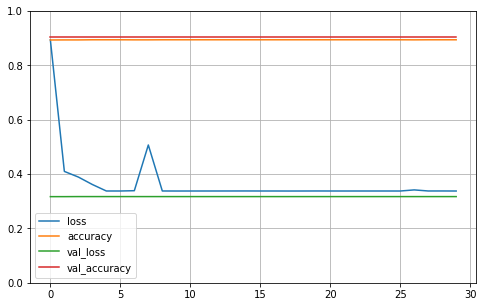

In [107]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # Wyznacza zakres osi pionowej od 0 do 1
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV

def search_for_best_parameter(classifier, parameters, scoring):
    clf = GridSearchCV(classifier, parameters, n_jobs=-1, cv=3, scoring=scoring)
    clf.fit(X_train, y_train)

    print('Best parameters found :\n', clf.best_params_)

scores = ['balanced_accuracy', 'precision', 'recall', 'f1']

parameter_space = { 
    'n_neighbors': range(1,20),
    'leaf_size': range(5, 100, 5)
}

for score in scores :
    search_for_best_parameter(KNeighborsClassifier(), parameter_space, score)



In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


knn_class = [
    ("KNN (1 nn, 70 leaf size)", KNeighborsClassifier(1, leaf_size=70)),
    ("KNN (2 nn, 30 leaf size)", KNeighborsClassifier(2, leaf_size=30)),
    ("KNN (14 nn, 30 leaf size)", KNeighborsClassifier(14, leaf_size=30)),
]

svm_class = [
    ("SVM (rbf1) ", SVC(random_state=r_state, kernel="rbf", C=100, degree=5, probability=True)),
    ("SVM (rbf2)", SVC(random_state=r_state, kernel="rbf", C=1, degree=2, probability=True)),
    ("SVM (rbf3)", SVC(random_state=r_state, kernel="rbf", C=10, degree=2, probability=True)),
]

mlp_class = [
    ("MLP1 ", MLPClassifier(max_iter=150, learning_rate='adaptive', random_state=r_state, random_state=(150, 100, 50), activation='logistic', solver='adam')),
    ("MLP2 ", MLPClassifier(max_iter=150, learning_rate='adaptive', random_state=r_state, random_state=(120, 80, 40), activation='relu', solver='lbfgs')),
    ("MLP3 ", MLPClassifier(max_iter=100, learning_rate='adaptive', random_state=r_state, random_state=(120, 80, 40), activation='tanh', solver='lbfgs'))
]

dtree_class = [
    ("DECISION TREE (max depth = 1)", DecisionTreeClassifier(max_depth=1, random_state=r_state)),
    ("DECISION TREE (max depth = 2)", DecisionTreeClassifier(max_depth=2, random_state=r_state)),
    ("DECISION TREE (max depth = 4)", DecisionTreeClassifier(max_depth=4, random_state=r_state)),
    ("DECISION TREE (max depth = 6)", DecisionTreeClassifier(max_depth=6, random_state=r_state)),
    ("DECISION TREE (max depth = 8)", DecisionTreeClassifier(max_depth=8, random_state=r_state)),
    ("DECISION TREE (max depth = 10)", DecisionTreeClassifier(max_depth=10, random_state=r_state)),
    ("DECISION TREE (max depth = 12)", DecisionTreeClassifier(max_depth=12, random_state=r_state)),
]

random_forest_classifier = RandomForestClassifier(random_state=r_state, n_estimators=140)

classifiers = [
    ("Nearest Neighbors", knn_vclass),
    ("Linear SVM", svm_vclass),
    ("Decision Tree", dtree_vclass),
    ("Random Forest", random_forest_classifier),
    ("Multilayer Perceptron", mlp_vclass)
]

eclf = VotingClassifier(estimators = classifiers, voting = 'soft', weights = [3, 2, 1, 1])



def score_for_vclassifiers(classificator, name):
    vclass = VotingClassifier(estimators=classificator, voting='soft')
    vclass.fit(X_train, y_train)
    score = vclass.score(X_test, y_test)
    print(f"VotingClassifier for %s: %.2f%%"%(name, (score * 100))) 
    return vclass


def savePlot(figure, class_name, metric_type):
    figure.savefig(dir_measures + '/' + class_name + '-' + metric_type +'.png')


def score_evaluation(classificator,  classificator_name, save_metrics = False):
    print(f"SCORE FOR %s\n"%  classificator_name)

    y_pred_prob = classificator.predict_proba(X_test)

    # ROC CURVE

    roc_plot = skplt.metrics.plot_roc_curve(y_test, y_pred_prob)

    # PRECISION RECALL
    prec_recall_plot = skplt.metrics.plot_precision_recall(y_test, y_pred_prob)

    print("CONFUSION MATRIX ")
    y_pred_normal = classificator.predict(X_test)

    conf_matrix_plot = skplt.metrics.plot_confusion_matrix(y_test, y_pred_normal, labels =[1, 0])

    conf_matrix = confusion_matrix(y_test, y_pred_normal, labels =[1, 0])

    print(conf_matrix)

    tp = conf_matrix [0][0]
    fp = conf_matrix [0][1]
    fn = conf_matrix [1][0]
    tn = conf_matrix [1][1]
    print("\ nTrue positive: ", tp)
    print("False positive: ", fp)
    print("False negative: ", fn)
    print("True negaitve: ", tn)

    # ACC
    from sklearn.metrics import accuracy_score
    acc_score = accuracy_score(y_test, y_pred_normal)

    acc_str = f"Accuracy : %.2 f%%"%(acc_score * 100)
    print('\n', acc_str)

    from sklearn.metrics import f1_score
    fscore = f1_score(y_test, y_pred_normal, average = None)

    f1score_str = "F1 score [ NOT SEIZURE, SEIZURE ] "+ str(fscore)
    print(f1score_str)

    # SENSITIVITY
    def safe_div(n, d):
        return n / d if d else 0

    sensitivity = safe_div(tp, (tp + fn))
    sensitivity_str = f"Sensitivity (true positive rate): %.2 f%%"%(
    sensitivity * 100)
    print(sensitivity_str)

    # SPECIFITY
    specifity = safe_div(tn, (tn + fp))
    specifity_str = f"Specificity (true negative rate): %.2f %%\ n"%(
    specifity * 100)
    print(specifity_str)

    # PRECISION
    precision = safe_div(tp, (tp + fp))
    precision_str = f"Precision: %.2 f%%\ n"%(
    precision * 100)
    print(precision_str)

    if sav_metrics:
        savePlot(roc_plot.get_figure(),  classificator_name, "ROC ")
        savePlot(prec_recall_plot.get_figure(),  classificator_name, "PRECISIONRECALL ")
        savePlot(conf_matrix_plot.get_figure(),  classificator_name, "CONFUSIONMATRIX ")
        lines = [ acc_str, f1score_str, sensitivity_str, specifity_str, precision_str ]
        with open(dir_measures + sep +  classificator_name +'-metrics.txt', 'w') as f:
            f.write('\n'.join(lines))

NameError: name 'KNeighborsClassifier' is not defined